We want to simulate high-congestion, high-gas-price events, so let's look at a couple past ones. We don't need to develop a complex model here (I'm not that good at math, and it'll probably over-fit anyway), but let's find at least a couple general patterns to get us started. My hypothesis is that prices generally have a stable baseline, but then spike massively on small time frames.

I got together a couple datasets, courtesy of [this Dune query](https://dune.com/queries/2693842), zooming in on a couple days that I found particularly high-congestion events from this chart of [average gas prices](https://etherscan.io/chart/gasprice).

Brief aside: I found out that trying to do these graphs as bar charts would take ~5 minutes to render, while doing them as line charts takes ~5 seconds. Turns out rectangles are harder to render than lines.

First let's get an idea of what the gwei price looks like over a couple days of wild gas prices, and highlight any blocks with >= 99 percentile gas prices.

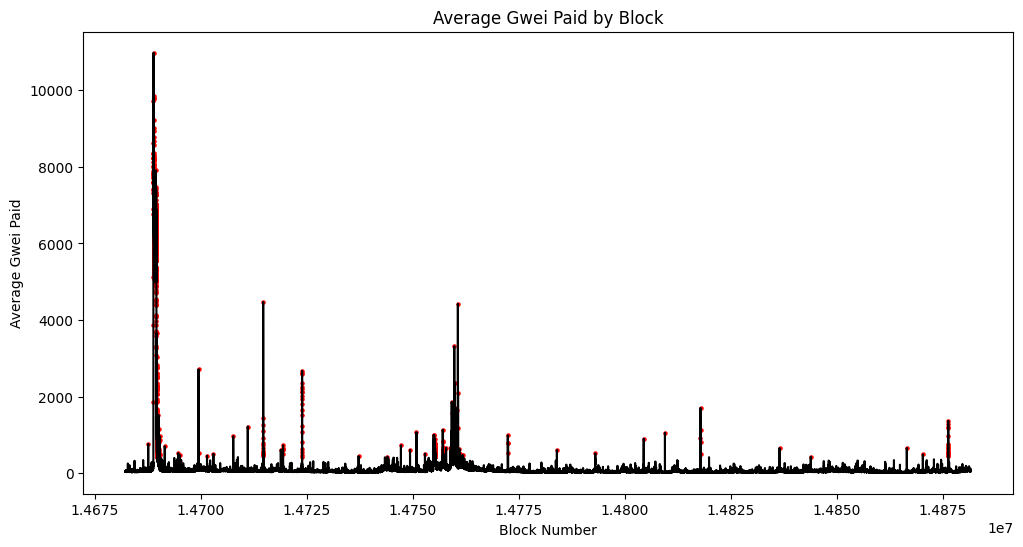

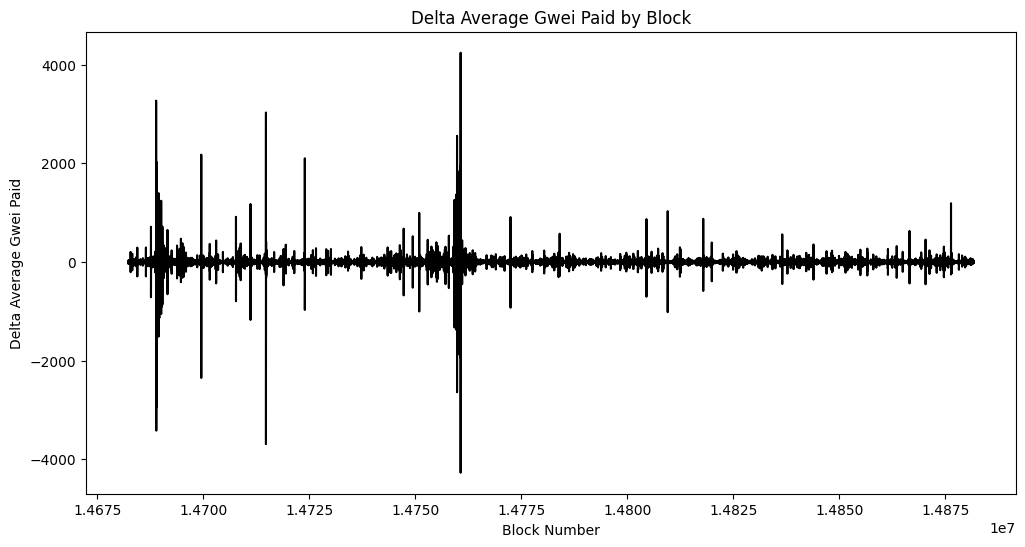

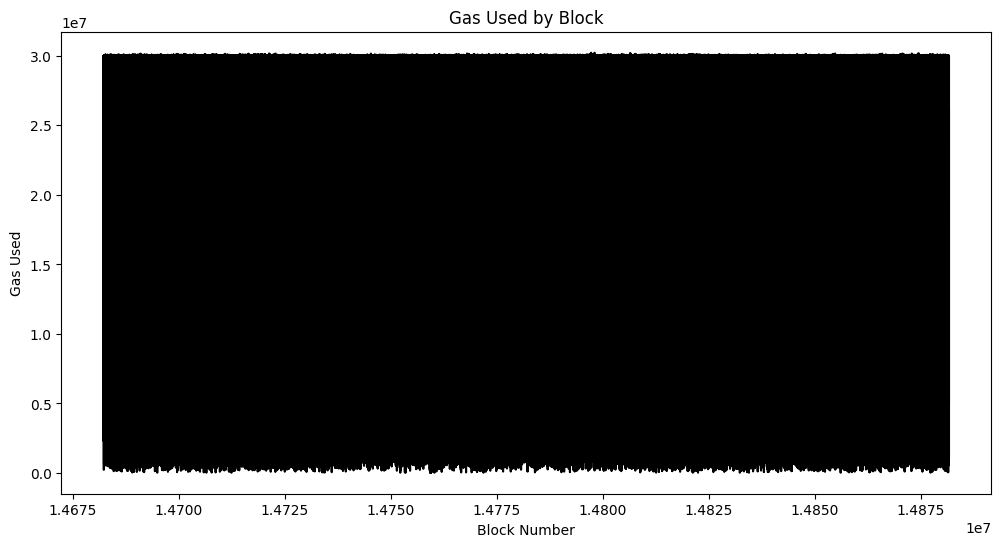

In [235]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from ydata_profiling import ProfileReport

gas_data = pd.read_csv('2022-04-30-to-2022-06-01.csv')
gas_data['block_number'] = gas_data['block_number'].astype(int)
gas_data["delta_average_gwei"] = gas_data["average_gwei_paid"].diff()
gas_data_gwei_sorted = gas_data.sort_values(by="average_gwei_paid", ascending=False)
gas_data_delta_sorted = gas_data.sort_values(by="delta_average_gwei", ascending=False)

# Uncomment to get a nice HTML overview of the data. The data has already been cleaned, and has a lot of extremes.
# profile = ProfileReport(ethereum_gas_data, title="Profiling Report")
# profile.to_notebook_iframe()

## Average Gwei Paid by Block chart

# Calculate the 99th percentile
percentile_99 = np.percentile(gas_data['average_gwei_paid'], 99)

fig, agpb = plt.subplots(figsize=(12, 6))

line = agpb.plot(gas_data['block_number'], gas_data['average_gwei_paid'], color='black')

# Color points above the 95th percentile
above_99 = gas_data['average_gwei_paid'] > percentile_99
agpb.scatter(gas_data.loc[above_99, 'block_number'], gas_data.loc[above_99, 'average_gwei_paid'], color='red', s=5)

agpb.set_xlabel('Block Number')
agpb.set_ylabel('Average Gwei Paid')
agpb.set_title('Average Gwei Paid by Block')

## Delta Average Gwei Paid by Block chart

fig, delta = plt.subplots(figsize=(12, 6))
delta.set_xlabel('Block Number')
delta.set_ylabel('Delta Average Gwei Paid')
delta.set_title('Delta Average Gwei Paid by Block')
delta.plot(gas_data['block_number'], gas_data['delta_average_gwei'], color='black')

## Gas Used by Block chart

fig, gas_used = plt.subplots(figsize=(12, 6))
gas_used.set_xlabel('Block Number')
gas_used.set_ylabel('Gas Used')
gas_used.set_title('Gas Used by Block')
gas_used.plot(gas_data['block_number'], gas_data['total_gas_used'], color='black')

plt.show()

Seems the hypothesis is holding. There's a relatively stable baseline with massive spikes, but even that baseline is all over the damn place. Let's zoom in on some of the highest gas events. 

In [236]:
num_highlighted = 10
block_buffer = 500
highlighted_blocks_list = []

# Build out our highlighted blocks, which we want to focus on individual events, and often the largest gas events are
# highly clustered.
# Note: I'm pretty sure that this is a naive and inefficient way to do this, but we only need a few highlights, so fuck it.
for i, high_gas_block in gas_data_gwei_sorted.iterrows():
    if not any(abs(high_gas_block['block_number'] - selected_row['block_number']) <= block_buffer for selected_row in highlighted_blocks_list):
        # Add the current row to the selected rows list
        highlighted_blocks_list.append(high_gas_block)
    if len(highlighted_blocks_list) >= num_highlighted:
        break

highlighted_blocks = pd.DataFrame(highlighted_blocks_list)
highlighted_blocks['block_number'] = highlighted_blocks['block_number'].astype(int)
print("Unique Gas Events")
display(highlighted_blocks)

gas_data_delta_sorted.head(10)


Unique Gas Events


,block_number,total_gas_used,average_gwei_paid,max_gwei_paid,delta_average_gwei
6416,14688914,2562113.0,10982.298876,60000.000000,2035.712770
6949,14689454,6372794.0,7906.876895,46709.262508,1396.408495
31534,14714775,30054347.0,4468.867444,18401.432860,3031.161337
76154,14760687,1182022.0,4419.474509,8689.541468,4243.593876
75317,14759843,1249017.0,3310.251540,11269.378226,2557.694940
16730,14699523,29966888.0,2710.670838,25000.000000,2176.882141
40431,14723951,30015994.0,2672.078855,7000.000000,422.291378
74718,14759233,2261112.0,1860.271557,8597.203450,1260.300099
131703,14817909,29982160.0,1701.066225,5600.000000,779.110634
7549,14690070,10904486.0,1518.335142,7823.000000,1242.079213


,block_number,total_gas_used,average_gwei_paid,max_gwei_paid,delta_average_gwei
76154,14760687,1182022.0,4419.474509,8689.541468,4243.593876
6379,14688877,29996997.0,5124.253488,8747.000000,3271.702073
31534,14714775,30054347.0,4468.867444,18401.432860,3031.161337
6381,14688879,29990964.0,6888.464031,78999.000000,3014.170255
6382,14688880,29991554.0,9723.784602,50272.983810,2835.320571
75317,14759843,1249017.0,3310.251540,11269.378226,2557.694940
16730,14699523,29966888.0,2710.670838,25000.000000,2176.882141
40421,14723941,29993638.0,2195.566740,5851.345979,2103.078726
6416,14688914,2562113.0,10982.298876,60000.000000,2035.712770
76197,14760731,1506986.0,2084.128851,7906.358081,1950.047986


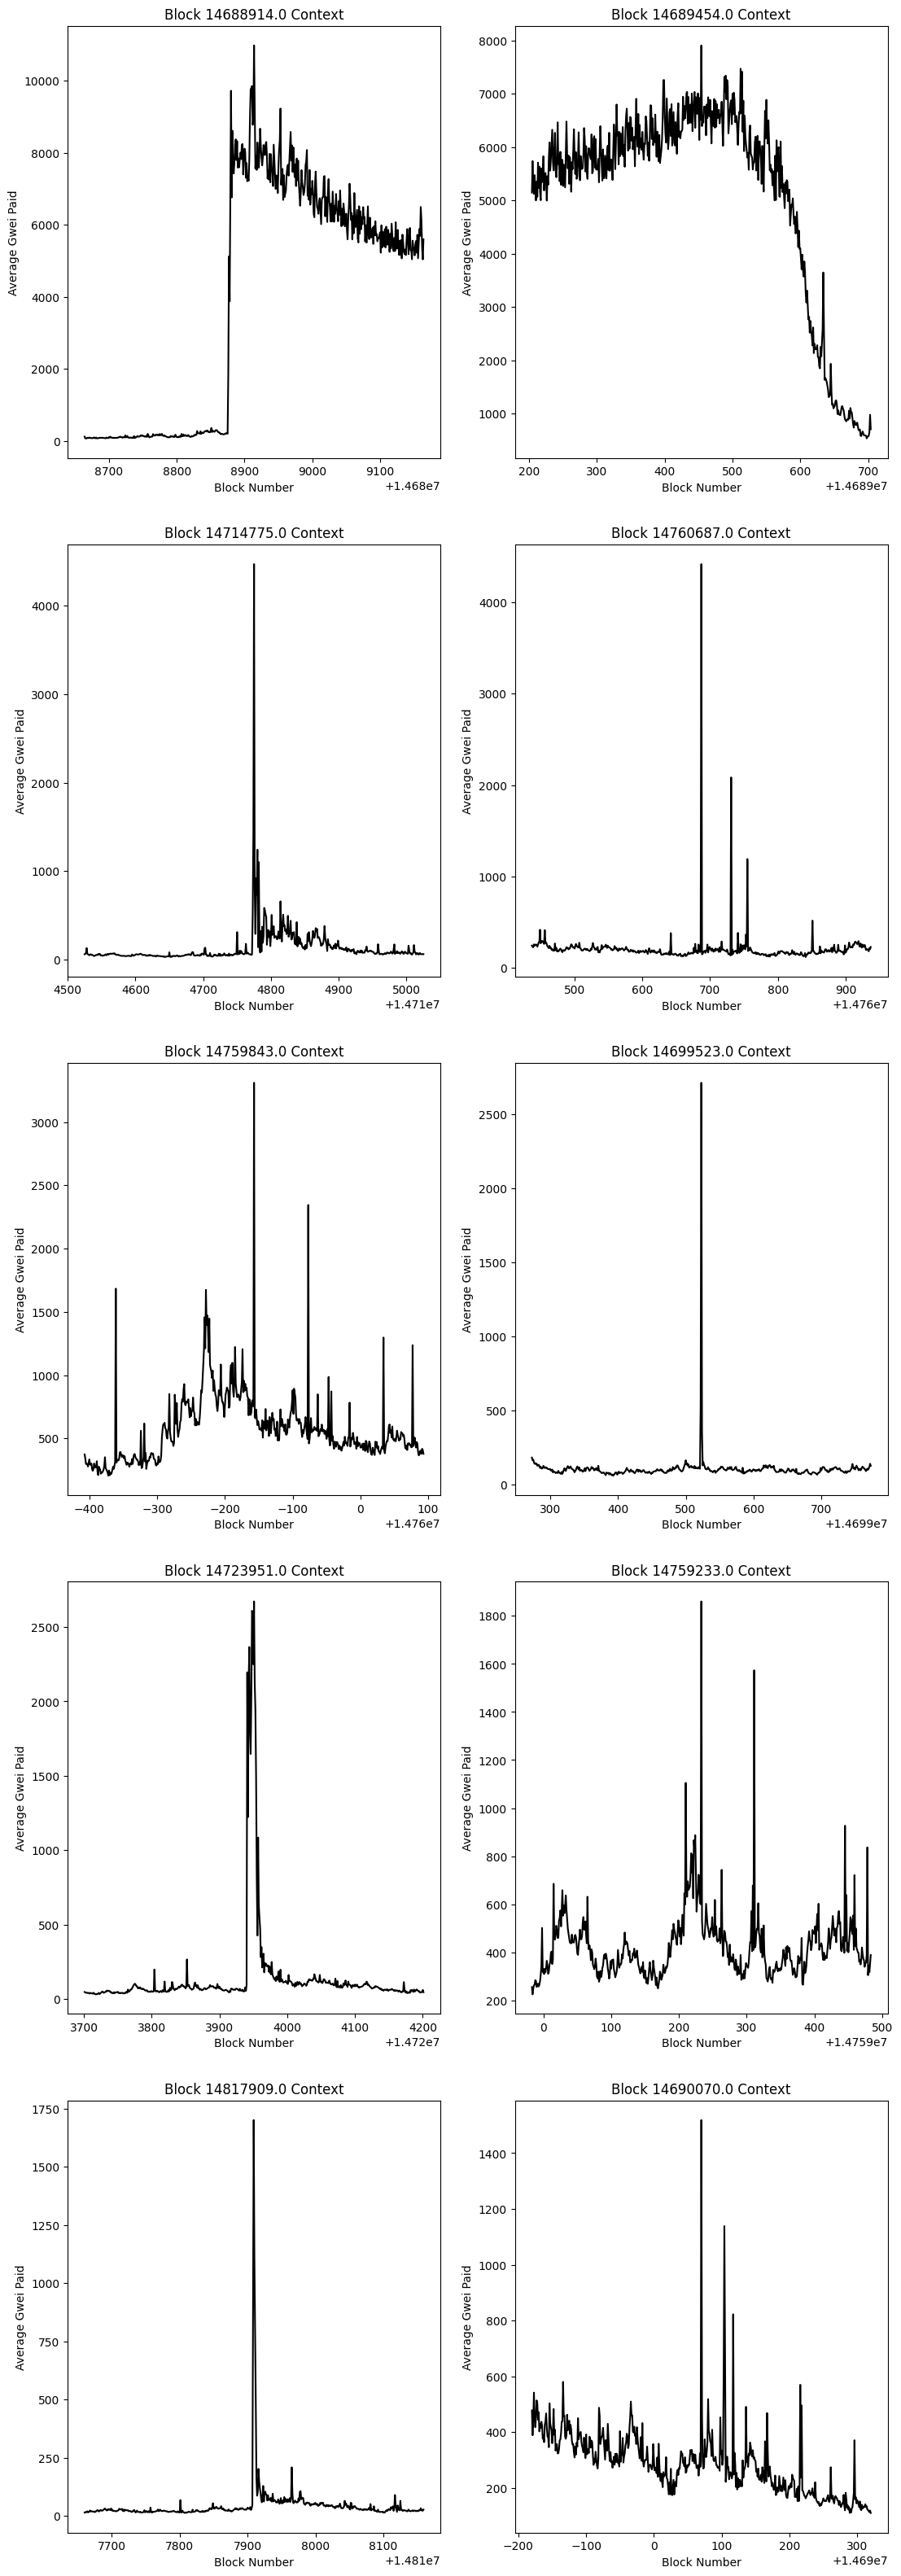

In [237]:
fig, highlight_ax = plt.subplots(nrows=num_highlighted//2, ncols=2, figsize=(13, num_highlighted*4))

for row in range(num_highlighted//2):
    for col in range(2):
        block = highlighted_blocks.iloc[row * 2 + col]
        block_context = gas_data.loc[(gas_data['block_number'] >= block['block_number'] - 250) & (gas_data['block_number'] <= block['block_number'] + 250)]
        highlight_ax[row][col].set_title(f"Block {block['block_number']} Context")
        highlight_ax[row][col].set_xlabel('Block Number')
        highlight_ax[row][col].set_ylabel('Average Gwei Paid')
        highlight_ax[row][col].plot(block_context['block_number'], block_context['average_gwei_paid'], color='black')


So there's two patterns it looks like, a massive spike that sends the whole market into disarray for a while, and a random spike that drops right back down to the baseline, likely a some [MEV or complex swaps](https://etherscan.io/txs?block=14760687). Alright, so let's emulate both. We can spike and keep it mostly spiked, or spike and drop it back down.